In [1]:
"""
First attempt to make a NN solve the inverse DTMM problem,
instead of the numerical minimization of difference
between experiment and numerical model.

The sample is a liquid crystal in a photopatterned cell.
Its alignment is characterized by the pattern and some material parameters,
such as INTENSITY, DFACTOR, TWIST, XI
We know the pattern (set in the dtmm code below),
but the material parameters are unknown.

Placing the sample under the microscope and taking a sequence of 
images, each one under the pre-determined configuration of
polarizers and lambda plates produces a unique array of images, which represents our input data.

These images can also be numerically simulated using the dtmm library.

Written by Simon.
"""

'\nFirst attempt to make a NN solve the inverse DTMM problem,\ninstead of the numerical minimization of difference\nbetween experiment and numerical model.\n\nThe sample is a liquid crystal in a photopatterned cell.\nIts alignment is characterized by the pattern and some material parameters,\nsuch as INTENSITY, DFACTOR, TWIST, XI\nWe know the pattern (set in the dtmm code below),\nbut the material parameters are unknown.\n\nPlacing the sample under the microscope and taking a sequence of \nimages, each one under the pre-determined configuration of\npolarizers and lambda plates produces a unique array of images, which represents our input data.\n\nThese images can also be numerically simulated using the dtmm library.\n\nWritten by Simon.\n'

In [2]:
# DTMM SIMULATION SETTINGS
"""
This part is necessary to produce the correct simulation results.
It is just a copy-paste from the minimize_dtmm files.
"""

# User constants and configuraion:
import numpy as np
from dtmm.conf import CDTYPE, FDTYPE
import dtmm

SHAPE = (60,16,16) # data shape (n layers, n pixels height, n pixels width)
# which polarization states of input light we compute for.

# POLARIZATIONS = [(0,1),(1,0)]

# # wavelength used for single-wavelength calculation
# WAVELENGTH = 785
# # intensity used for single-wavelength calculation
# INTENSITY = 1e6
# # wave propagation parameter for single-wavelength calculation
# BETA = 0 # see dtmm documentation on this, the beta parameter n*sin(theta)
# # The phi angle of the wave, only matters if BETA != 0
# PHI = 0 

# wavelength range for the multi-wavelength calculation
WAVELENGTHS = np.linspace(380,780,11) # nm
# wave intensity for each of the waves of the multi-wavelength calculation.
# INTENSITIES = [INTENSITY]*len(WAVELENGTHS)
# # wave beta parameter for each of the waves of the multi-wavelength calculation.
# BETAS = [BETA]*len(WAVELENGTHS) 
# # wave phi parameter for each of the waves of the multi-wavelength calculation.
# PHIS = [PHI]*len(WAVELENGTHS) 

# sample thickness
THICKNESS = 3.1 # microns
# imaged region 
WIDTH = 40. # microns
HEIGHT = 40. # microns

# cover/substrate glass refractive index
NCOVER = 1.5


# # STOP! Computed constants, Do not set manually!
# ########################################################################
# STEPSIZE = THICKNESS/SHAPE[0]*1000 #nm
# # unitless wave number of fundamental and shg waves. Do not set manually!
# K0 = 2*np.pi/WAVELENGTH * STEPSIZE
# K0S = 2*np.pi/WAVELENGTHS * STEPSIZE

# # epsilon and euler angles for the cover glass
# EPSILON0 = np.ones((3,)) * NCOVER **2
# ANGLES0 = np.zeros((3,)) 

# # matrices size in MB for single-wavelength run
# MB_WAVELENGTH = 2* SHAPE[0]*SHAPE[1]*SHAPE[2]*4*4/1024/1024 * np.dtype(CDTYPE).itemsize 
# # matrices size in MB for single-pixel run
# MB_PIXEL = 2* len(WAVELENGTHS) * SHAPE[0]*4*4/1024/1024 * np.dtype(CDTYPE).itemsize 
# # required memroy size for full computation
# GB_FULL = 2*len(WAVELENGTHS)* SHAPE[0]*SHAPE[1]*SHAPE[2]*4*4/1024/1024/1024 * np.dtype(CDTYPE).itemsize 

# # matrices size in MB for single-wavelength run
# MB_WAVELENGTH_F = len(POLARIZATIONS)*MB_WAVELENGTH//SHAPE[0]
# # matrices size in MB for single-pixel run
# MB_PIXEL_F = len(POLARIZATIONS)*MB_PIXEL//SHAPE[0]
# # required memroy size for full computation
# GB_FULL_F = len(POLARIZATIONS)*GB_FULL//SHAPE[0]

# ####################################################################

# MATERIAL PARAMETERS:

MOD= 1/40. #modulation constant
# TWIST = 5* np.pi/180 # max mid-plane twist
# KSI= 1/0.2 # the ksi constant - see :funf:`ampl`
AMP = -40 * np.pi/180 # surface alignment angle 

# PARAMS = np.asarray([TWIST,KSI])

def ampl(z, ksi = 0.2):
    return np.exp(-(-2.*(z/THICKNESS)**2 + 1./2.)*(ksi))
    
def psi(x,y,z, *params):
    return 0.0 # For uniaxial set to zero or any value
    
def theta(x,y,z, *params):
    return np.pi/2

def phi(x,y,z, *params):
    amp = AMP#params[0]
    mod = MOD
    twist = params[0]
    ksi = params[1]
    return  amp*(ampl(z,ksi))* np.sin(2*np.pi*mod *(x))* np.sin(2*np.pi*mod *(y)) + twist*(1 - (ampl(z, ksi))) 

# computed parameters. Do not change these!
#//////////////////////////////////////////

# range of coordinates in z,y, and x directions
z = np.linspace(-THICKNESS/2,THICKNESS/2, SHAPE[0])
y = np.linspace(0,HEIGHT, SHAPE[1])
x = np.linspace(0,WIDTH, SHAPE[2])

# we use ij indexing in dtmm, the first axis is (i = z), then height (j = y), then width (k = x)
zzz,yyy,xxx = np.meshgrid(z,y,x, indexing = 'ij')

def get_angles(*params):
    # create an empty placehold of floats
    angles = np.empty(SHAPE+(3,), dtype = FDTYPE)
    # fill the array
    angles[...,0] = psi(xxx,yyy,zzz, *params)
    angles[...,1] = theta(xxx,yyy,zzz, *params)
    angles[...,2] = phi(xxx,yyy,zzz, *params)
    return angles


def calculate_field(*params):
    # we use numpy broadcasting rules here, so we add two empty axes  to match the angles array shape
    epsilon = np.zeros((SHAPE[0],1,1,3))
    epsilon[...,0] = 1.52**2
    epsilon[...,1] = 1.52**2
    epsilon[...,2] = 1.765**2
    #epsilon = dtmm.EpsilonCauchy(shape = SHAPE, n = 2) 
    #epsilon.coefficients[...,0:2,0] = 1.47  # a term, just set to refractive index
    #epsilon.coefficients[...,2,0] = 1.66  # a term, just set to refractive index
    #epsilon.coefficients[...,0:2,1] = 874/1000000. # b term ordinary
    #epsilon.coefficients[...,2,1] = 10256/1000000. # b term extraordinary
    angles = get_angles(*params[1:])
    d = np.ones(SHAPE[0])*np.abs(params[0])
    optical_block = d,epsilon,angles
    pixelsize = THICKNESS/SHAPE[0]*1000
    
    field_data_in = dtmm.illumination_data((SHAPE[1], SHAPE[2]), WAVELENGTHS,
        pixelsize = pixelsize , diffraction = False)
    field_data_out = dtmm.transfer_field(field_data_in, [optical_block], diffraction = 0, split_wavelengths=False)
    return field_data_out
    

def calculate_images(*params, exp_config):
    PARAMS = np.asarray(params[1:])
    field_out = calculate_field(*PARAMS)
    cmf = dtmm.color.load_tcmf(WAVELENGTHS, illuminant = "A")
    viewer = dtmm.field_viewer(field_out, diffraction = False, cmf = cmf)
    images = np.empty((len(exp_config), SHAPE[1], SHAPE[2], 3))
    
    i=-1
    for p, a, r in exp_config:
        i += 1
        viewer.set_parameters(polarizer = p, analyzer = a, intensity = params[0], retarder = r)
        im = viewer.calculate_image() # np array
        images[i] = im
    return images

In [9]:
# IMPORTS AND INITIAL SETTINGS:

import numpy as np
import itertools
import matplotlib.pyplot as plt
import time
import glob
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, InputLayer, TimeDistributed, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from tqdm import tqdm
from matplotlib import cm
from matplotlib.colors import Normalize
import datetime

# timestamp:
timestamp = str(datetime.datetime.now()).replace(":", ".")[:-10]

plt.rcParams.update({"figure.dpi":150,
                     "axes.grid":True,
                     "grid.color": "grey",
                     "grid.linestyle": ":",})


FILENAME = "test_new_150k"
SAVEFOLDER= "D:\\Users Data\\Simon\\MachineLearning\\saved_data\\"

In [10]:
# FUNCTION DEFINITIONS

# def generate_labels():   
#     """
#     Generate an array of parameter labels, taking into account 
#     the "grid" values (evenly spaced points from min to max of each parameter)
#     as well as the additional values,
#     randomly drawn from the normal distribution, centered around 
#     each "grid" value and with sigma = sigma_percentage * (max-min)
    
#     To avoid 4x for loop, itertools.product is used to create the 
#     array with all combinations.

#     Returns:
#         np.ndarray: A 2D array containing the generated labels with variations. 
#                     The shape of the array is (NSTEPS_EACH_PAR**N_PARAMS * NVAR, N_PARAMS), 
#                     where:
#                         - `NSTEPS_EACH_PAR` is the number of steps for each parameter.
#                         - `N_PARAMS` is the number of parameters (intensity, dfactor, twist, ksi).
#                         - `NVAR` is the number of variations for each parameter combination.
#     """
    
#     # Create an array of all possible grid combinations in parameter space:
#     combinations = itertools.product(intensity_arr, dfactor_arr, twist_arr, ksi_arr) 
    
#     # Initialize an empty array for labels with predetermined size:
#     labels_arr = np.empty((NSTEPS_EACH_PAR**N_PARAMS * NVAR, N_PARAMS)) * 0
    
#     # Iterate through all parameter combinations and create their normal
#     # distributed variations:
#     i=-1
#     for intensity, dfactor, twist, ksi in combinations:
#         for n in range(NVAR): # number of variations:
#             i += 1
#             # draw a sample from a normal distribution centered around "grid" parameter values
#             # and a predetermined sigma:
#             intensity_i = np.random.normal(intensity, (intensity_max - intensity_min) * SIGMA_PERCENTAGE)
#             dfactor_i = np.random.normal(dfactor, (dfactor_max - dfactor_min) * SIGMA_PERCENTAGE)
#             twist_i = np.random.normal(twist, (twist_max - twist_min) * SIGMA_PERCENTAGE)
#             ksi_i = np.random.normal(ksi, (ksi_max - ksi_min) * SIGMA_PERCENTAGE)
        
#             # write to array of labels:
#             labels_arr[i] = np.array([intensity_i, dfactor_i, twist_i, ksi_i])

            
#     return labels_arr



def generate_data(labels_arr):   
    """
    Generate and save a dataset of simulated images for training,
    based on pre-calculated input labels.

    This function iterates over a given array of labels and generates corresponding 
    image data using the `calculate_images` function. 
    
    For each label set (e.g., intensity=1, dfactor=1, twist=1, xi=1),
    a sequence of several images is simulated, each taken under specific
    combinations of polarizers and lambda plates. This sequence of configurations is 
    always the same for all label sets.
    Of course, the same sequence of configurations must then be followed
    experimentally when using the trained NN.
    
    Why this approach and not learning each image individually?
    Beacuse each image can be created by many different polarizers/lamda plates configurations,
    leading to a non-bijective map.
    For real-world use, that would require propagating each image in the label set
    individually and then averaging the outputs (or some other messy approach).
    Furthermore, that would also lead to many more fitting parameters as all the
    polarizers/lambda plates would have to be fitted as well.
    
    So, by using a predetermined sequence of experimental configurations
    we do lose some flexibility but gain a lot in precision, granted by the
    bijective mapping and fewer fitting parameters.
    
    The images are of very small size (e.g. 11*11) to save memory.
    For the simulation, this size is set initially, for actual experimental data,
    there is a DIY function called "pixelate".
    
    So, the generated images are stored in a 5D NumPy array, which has a shape of:
    
            (number of label sets,
            number of different images (experiment configurations) for each label set,
            image dimensions 0,
            image dimensions 1,
            3 RGB color channels)
    
    
    Returns:
        np.ndarray: A 5D array of simulated images with the shape 
                    `(len(labels_arr), len(experiment_configurations), SHAPE[1], SHAPE[2], 3)`, 
                    where:
                        - `len(labels_arr)` is the number of label sets.
                        - `len(experiment_configurations)` is the number of experiment configurations.
                        - `SHAPE[1]` and `SHAPE[2]` are the dimensions of the images.
                        - `3` represents the RGB channels of the images.

    Note:
            - Due to high dimensionality, the amount of data to store quickly becomes huge!
            Consider using a less fine grid in label generation or less variations or less unknown material params.
    """
    
    # initialize an empty 5D array:
    images_arr = np.empty((len(labels_arr), len(experiment_configurations), SHAPE[1], SHAPE[2], 3))
    
    # iterate through all labels configurations:
    for i, label in tqdm(enumerate(labels_arr), desc="Generating images",total=len(labels_arr),ncols=100):
        # Simulate an array of images for every label:
        images = calculate_images(*label, exp_config=experiment_configurations)
        # images shape = (18, 11, 11, 3)
        # Write the image array of one label set to the full array
        if np.isnan(images).sum() > 0:
            print("Nan in label: ", label, i)
        images_arr[i] = images
        
    return images_arr
        


# Define the CNN model for regression of 4 parameters
def build_model(LR_init=0.0001):
    """
    Build a 2D convolutional neural network that can process a sequence of images as one element of input.
    This is taken care of with the TimeDistributed layer, which applies the SAME weights to each image in the 18-set.
    """
    cnn_model = Sequential([
        InputLayer(shape=(len(experiment_configurations), SHAPE[1], SHAPE[2], 3)),  # Input shape: 18 images of size 16x16 with 3 channels
        TimeDistributed(Conv2D(16, (3, 3), activation='relu')),
        TimeDistributed(MaxPooling2D((2, 2))),
        TimeDistributed(Conv2D(32, (3, 3), activation='relu')),
        TimeDistributed(MaxPooling2D((2, 2))),
        TimeDistributed(Flatten()),
        Flatten(), # len=len(exp config * 128? )
        Dense(1024, activation='relu'),
        Dense(512, activation='relu'),
        Dense(256, activation='relu'),
        Dense(128, activation='relu'),
        #Dense(64, activation='relu'),
        #Dropout(0.5),
        Dense(4)  # Output layer for 4 parameters (no activation for regression)
    ])
    
    # Compile the model
    cnn_model.compile(optimizer=Adam(learning_rate=LR_init),
                      loss=MeanSquaredError(),
                      metrics=["mean_absolute_error"])
    
    return cnn_model

#Dropout(0.5),  # Dropout before final Dense layers
#TimeDistributed(Conv2D(16, (3, 3), activation='relu', kernel_regularizer=l2(0.001))),



# maybe someone might consider such architecture without sharing layers and weights:
# Apply unique convolutional layers to each image in the set
# conv_outputs = [
#     Flatten()(
#         MaxPooling2D((2, 2))(
#             Conv2D(32, (3, 3), activation='relu')(
#                 MaxPooling2D((2, 2))(
#                     Conv2D(16, (3, 3), activation='relu')(input_layer[:, i, :, :, :])
#                 )
#             )
#         )
#     )
#     for i in range(18)
# ]
# # Concatenate all the flattened outputs
# concatenated = Concatenate()(conv_outputs)

# # Add fully connected layers
# dense_layer = Dense(128, activation='relu')(concatenated)
# output_layer = Dense(4)(dense_layer)  # Output layer for 4 parameters

# # Create the model
# model = Model(inputs=input_layer, outputs=output_layer)


In [12]:
# DATA GENERATION SETTINGS
"""
Settings for learning data generation.
"""

# Parameters settings:
RND_SIZE = 150000
N_PARAMS = 4 # number of all params to fit

# Universal experiment configuration sequence settings:
polarizers_arr = [90]
analizers_arr = [90, 120, 150, 180, 210, 240]
retarders_arr = ["none", "lambda/4", "lambda"]
experiment_configurations = list(itertools.product(polarizers_arr, analizers_arr, retarders_arr))

# Prepare ranges for each parameter:
intensity_min, intensity_max = 0.7,1.5
dfactor_min, dfactor_max = 0.5, 1
twist_min, twist_max = np.pi / 180 * 0, np.pi / 180 * 30  # max mid-plane twist
ksi_min, ksi_max = 1, 11 # the ksi constant - see :funf:`ampl`

# intensity_arr = np.random.uniform(intensity_min, intensity_max, N_RAND)
# dfactor_arr = np.random.uniform(dfactor_min, dfactor_max, N_RAND) 
# twist_arr = np.random.uniform(twist_min, twist_max, N_RAND) # max mid-plane twist
# ksi_arr = np.random.uniform(ksi_min, ksi_max, N_RAND) # the ksi constant - see :funf:`ampl`


###### Pre-generation checks #######
print(f"Labels will have shape ({RND_SIZE}, {N_PARAMS}) and will take approximately {RND_SIZE * N_PARAMS * 8e-9:.2f} GB of space." )
print(f"Images will have shape ({RND_SIZE}, {len(experiment_configurations)}, {SHAPE[1]}, {SHAPE[2]}, 3) and will take approximately {RND_SIZE * len(experiment_configurations) * SHAPE[1] * SHAPE[2] * 3 * 8e-9:.2f} GB of space." )
print(f"Approximate generation time: {RND_SIZE/12.5/60:.0f} minutes (= {RND_SIZE/12.5/60/60:.2f} hours)")

Labels will have shape (150000, 4) and will take approximately 0.00 GB of space.
Images will have shape (150000, 18, 16, 16, 3) and will take approximately 16.59 GB of space.
Approximate generation time: 200 minutes (= 3.33 hours)


In [13]:
# CREATE TRAINING DATA:
"""
Create training data. The process is described in more detail in the function
definitions section.

For each learning element, we generate one label set (intensity, dfactor, twist, xi),
following the random uniform distribution within predefined ranges.
A full array of label sets is the final output.

Using this label sets array, we generate learning data for each label set.
For each one, we generate a sequence of (18?) images under universally predeterimend
"experimental conditions" (polarizers, lambda plates etc).
The simulations are done with the dtmm calculate_images.

The final output is a 5-dimensional array.
"""


# # OPTION A: BUILD FROM SCRATCH:
# labels_arr = np.random.uniform(low=[intensity_min, dfactor_min, twist_min, ksi_min],
#                                high=[intensity_max, dfactor_max, twist_max, ksi_max],
#                                size=(RND_SIZE, 4))
# np.save(f"{SAVEFOLDER}labels_arr{FILENAME}.npy", labels_arr)

# images_arr = generate_data(labels_arr)
# np.save(f"{SAVEFOLDER}images_arr{FILENAME}.npy", images_arr)

# OPTION B: LOAD
labels_arr = np.load(f"{SAVEFOLDER}labels_arr{FILENAME}.npy")[:100000]
images_arr = np.load(f"{SAVEFOLDER}images_arr{FILENAME}.npy")[:100000]

In [14]:
# NAN AND INF CHECKS, shuffle:

print("BEFORE REMOVAL:")
print("length im", len(images_arr))
print("length labels", len(labels_arr))
# print("nans in images", np.isnan(images_arr.flatten()).sum())  # Check for NaNs
# print("infs in images", np.isinf(images_arr.flatten()).sum())  # Check for infinities
# print("nan indices", np.argwhere(np.isnan(images_arr).any(axis=(1,2,3,4))).flatten())
# print("inf indices", np.argwhere(np.isinf(images_arr).any(axis=(1,2,3,4))).flatten())

nan_indices = np.argwhere(np.isnan(images_arr).any(axis=(1,2,3,4))).flatten()
inf_indices = np.argwhere(np.isinf(images_arr).any(axis=(1,2,3,4))).flatten()
remove_indices = np.concatenate((nan_indices, inf_indices))
images_arr = np.delete(images_arr, remove_indices, axis=0)
labels_arr = np.delete(labels_arr, remove_indices, axis=0)

print("AFTER REMOVAL:")
print("length im", len(images_arr))
print("length labels", len(labels_arr))
# print("nans in images", np.isnan(images_arr.flatten()).sum())  # Check for NaNs
# print("infs in images", np.isinf(images_arr.flatten()).sum())  # Check for infinities
# print("nan indices", np.argwhere(np.isnan(images_arr).any(axis=(1,2,3,4))).flatten())
# print("inf indices", np.argwhere(np.isinf(images_arr).any(axis=(1,2,3,4))).flatten())

# shuffle and split into train and test sets (random state 42 ensures reproducible results):
x_train, x_test, y_train, y_test = train_test_split(images_arr, labels_arr, shuffle=True, test_size=0.2, random_state=42)

BEFORE REMOVAL:
length im 100000
length labels 100000
AFTER REMOVAL:
length im 100000
length labels 100000


In [ ]:
# BUILDING AND TRAINING THE NEURAL NETWORK
"""
Initialize and train the neural network.

#-------------- SECTION COPIED FROM ML_electrophoresis FILE (START) --------------------#

The actual neural network part is arguably easier to understand than
the data preparation part. At least for this specific case.

Neural network takes an input and propagates it through the whole network,
until an output comes out.
The general architecture of a NN looks like a series of layers, each layer
consisting of nodes. Each node from one layer can be (often is) connected to
all nodes from the next layer. The nodes perform a summation operation on all
their inputs and the connections have adjustable weights that multiply the signal.


Example of just one node in layer i and "height" j:

in_i-1_j-1 \                        / -- * weight i,j -> i+1, j-1 -- node i+1,j-1
            \                      /
in_i-1_j  --  node i_j (summation) ----- * weight i,j -> i+1, j   -- node i+1,j
            /                      \
in_i-1_j+1 /                        \ -- * weight i,j -> i+1, j+1 -- node i+1,j+1


There are also hidden "activation functions" (like ReLU, or tanh ...) after every node
that take the signal from the node as an argument. The output introduces non-linearity,
allowing to capture complex relations.

So, we can imagine that NN is capable of capturing certain features of the signal:
a signal with certain features will propagate through teh NN in a specific way, leading
to a certain kind of output. These features are not necessarily human-intuitive.

However, if we provide a pair of input AND the desired output, we can perform
a fitting operation, called back-propagation, where we slowly adjust all weights
in order to minimize the difference from desired output and actual output.
Because there are A LOT of weights, we need A LOT of data to achieve convergence.
Usually, we feed the same data many times, each time is called one "epoch".

There are many parameters that can be adjusted for better operation:
- NN architecture (number of elements in each layer, for example, this one is built like
                    input() - 512 - 256 - 128 - 64 - out(2))
                    (there also exist many different architecture types for different tasks)
- activation functions (e.g. sigmoids for classification, linear for regression)
- number of epochs
- validation split (percentage of data to use for validation)
- optimizer (e.g. Adam), learning rate value ...
- batch size (calculations in batches for memory efficiency)
- early stopping to avoid overfitting ...

#-------------- SECTION COPIED FROM ML_electrophoresis FILE (END) --------------------#

In case of image recognition machine learning, an approach of
CONVOLUTIONAL NEURAL NETWROKS is often used.

A convolution kernel is a smaller matrix which "travels" over the input (image) matrix
over all positions where it can cover elements of input matrix without falling out of bounds.
At each position, it computes element-wise multiplication and summation over all covering elements:

[[{ooo}............]             [[(out[i,j])....]
 [{ooo} --->.......]              [..............]
 [{ooo}............]              [..............]
 [..|..............]    ---->     [..............]
 [..v..............]              [..............]
 [.................]]             [..............]]


            m_max  n_max
 out[i,j] =   Σ      Σ   kernel[m, n] * input[i-m, j-n]
             m=0    n=0


The output image is a convolution of the input image with size = size(input)-size(kernel).

As we know, convolving an image with a convolution kernel is useful for applying filters
or effects to images, such as sharpening, bluring, edge detection, etc.
Each of this effects has a specific kernel.

e.g. 3x3 sharpening:
[[ 0  −1   0]
 [−1   5  -1]
 [ 0  -1   0]]

e.g. 3x3 Gaussian blur:
[[0.0613 0.1238 0.0613]
 [0.1238 0.2462 0.1238]
 [0.0613 0.1238 0.0613]]

The idea is that using the correct convolution kernels, we can extract features from the 
input data. So, by performing the convolution and "maxpooling" (reducing dimension
by only keeping the max value) we transform the input to a "feature map", which
only keeps the most essential information and should allow
the neural network to recognize characteristic features.
We can even stack several instances of similar convolution layers and then
lead it to a "normal" NN by unrolling the image to one long 1D array.

But how to know which kernels to use? That is the genious part: the elements in the kernel
are FITTED during the learning process, just like all other weights in the NN.

"""

# OPTION A: BUILD FROM SCRATCH:

lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-8)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Initialize the model:
cnn_model = build_model(LR_init=0.000001)

# Train the model:
history = cnn_model.fit(x_train, y_train, epochs=50, batch_size=16, validation_data=(x_test, y_test), callbacks=[lr_scheduler, early_stopping])
np.save(f"{SAVEFOLDER}history_{FILENAME}.npy", history)

# Save the entire model as a `.keras` zip archive.
cnn_model.save(f'{SAVEFOLDER}cnn_model_{FILENAME}.keras')
    

# # OPTION B: LOAD
# cnn_model = tf.keras.models.load_model(f'{SAVEFOLDER}cnn_model_{FILENAME}.keras')
# history = np.load(f"{SAVEFOLDER}history_{FILENAME}.npy", allow_pickle=True).item()

Epoch 1/50
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 321s 49ms/step - loss: 1.8224 - mean_absolute_error: 0.5902 - val_loss: 0.0350 - val_mean_absolute_error: 0.1129 - learning_rate: 1.0000e-05
Epoch 2/50
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 211s 42ms/step - loss: 0.0272 - mean_absolute_error: 0.0990 - val_loss: 0.0108 - val_mean_absolute_error: 0.0644 - learning_rate: 1.0000e-05
Epoch 3/50
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 210s 42ms/step - loss: 0.0106 - mean_absolute_error: 0.0614 - val_loss: 0.0053 - val_mean_absolute_error: 0.0419 - learning_rate: 1.0000e-05
Epoch 4/50
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 210s 42ms/step - loss: 0.0059 - mean_absolute_error: 0.0432 - val_loss: 0.0029 - val_mean_absolute_error: 0.0317 - learning_rate: 1.0000e-05
Epoch 5/50
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 212s 42ms/step - loss: 0.0039 - mean_absolute_error: 0.0350 - val_loss: 0.0045 - val_mean_absolute_error: 0.0386 - learning_rate: 1.0000e-05
Epoch 6/50
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 210s 42ms/step - loss: 0.0032 - mean_absolu

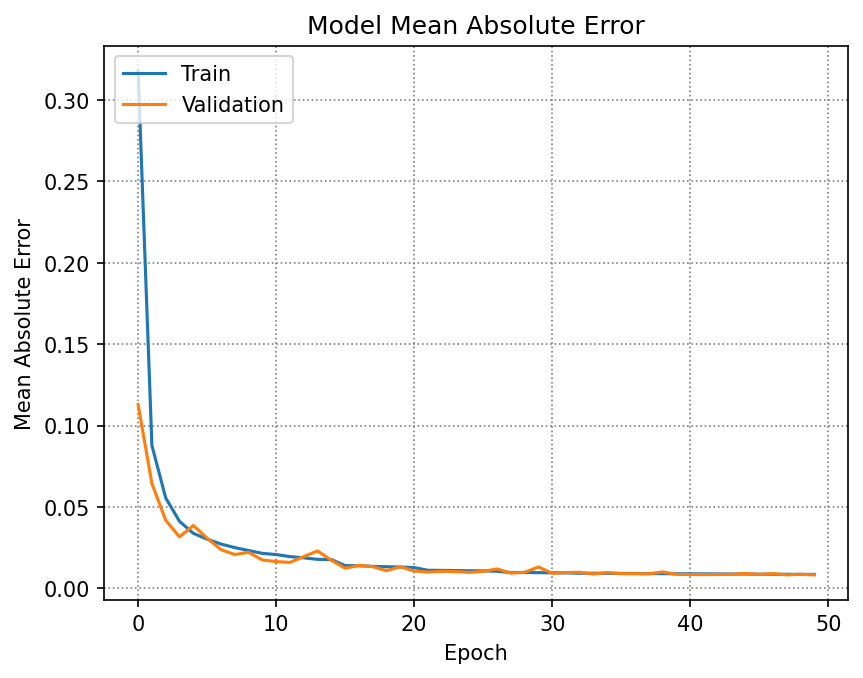

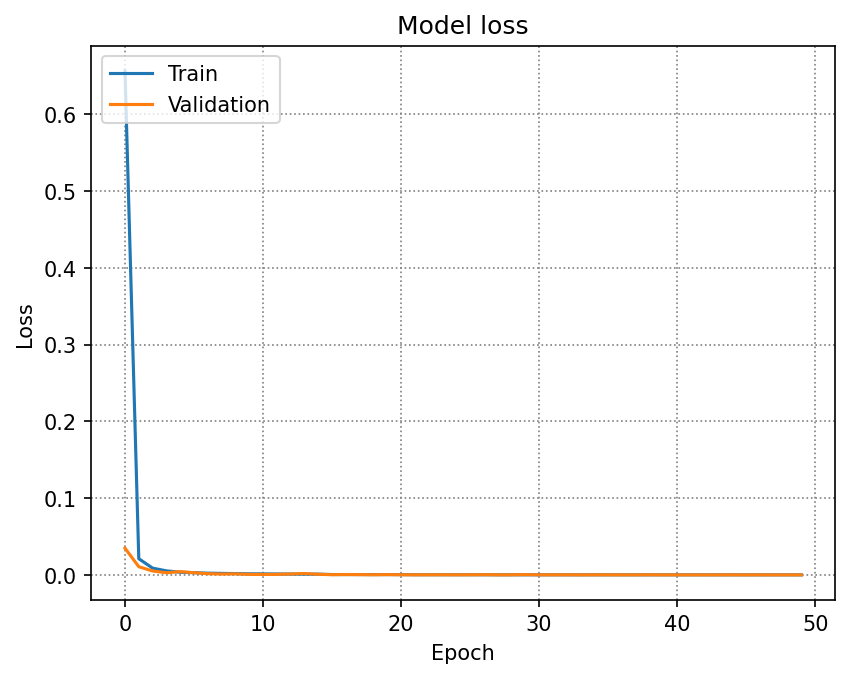

625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step
Mean Squared Error (MSE): 0.0002
Predicted:  [1.036034   0.51491904 0.13973783 2.6853716 ]
Label:  [1.04065668 0.50255956 0.13872459 2.62158488]
Predicted:  [0.83217394 0.6397362  0.06007479 8.230115  ]
Label:  [0.83030924 0.63760224 0.05729777 8.21915309]
Predicted:  [1.4503634  0.8106296  0.51115054 4.8194833 ]
Label:  [1.44813171 0.81540033 0.52231488 4.84037497]
Predicted:  [0.91910195 0.69789445 0.34280667 9.848996  ]
Label:  [0.92139774 0.69665594 0.34316244 9.87144592]
Predicted:  [1.0754957 0.7948474 0.3949835 8.481546 ]
Label:  [1.07529263 0.79516624 0.38630596 8.48151265]


<Figure size 960x720 with 0 Axes>

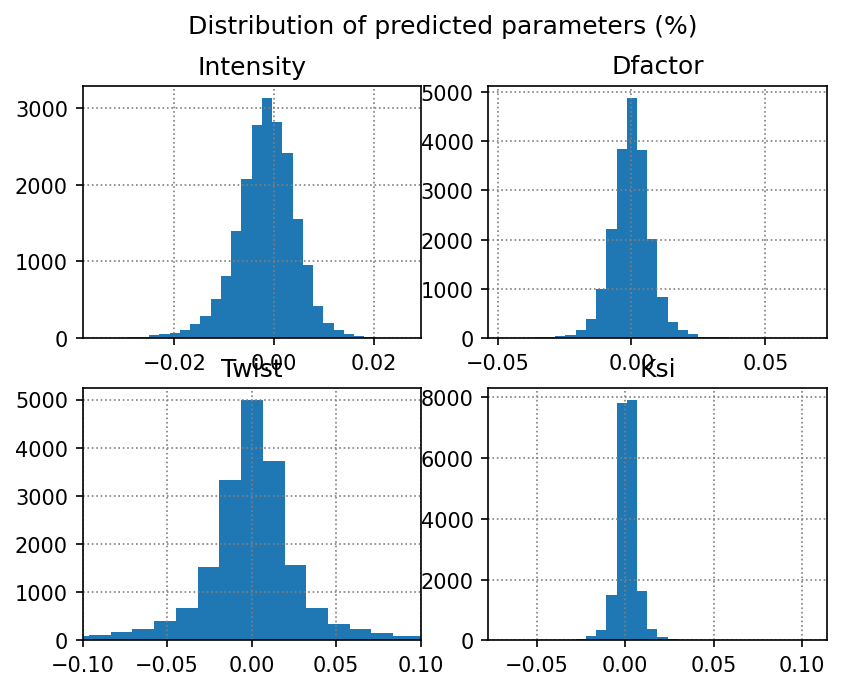

<Figure size 960x720 with 0 Axes>

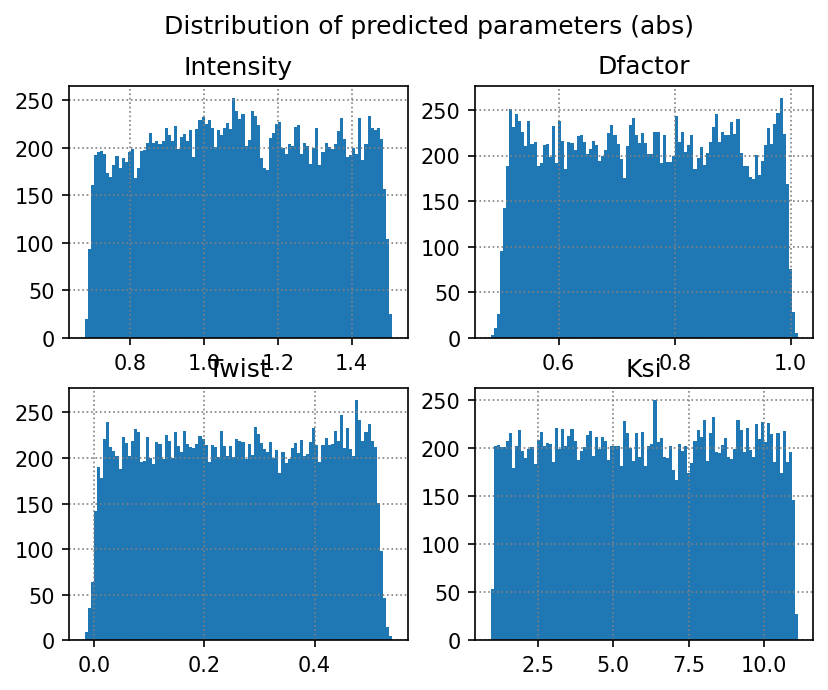

C:\Users\PolarBear2017\AppData\Local\Temp\ipykernel_13076\2613294790.py:77: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('viridis')


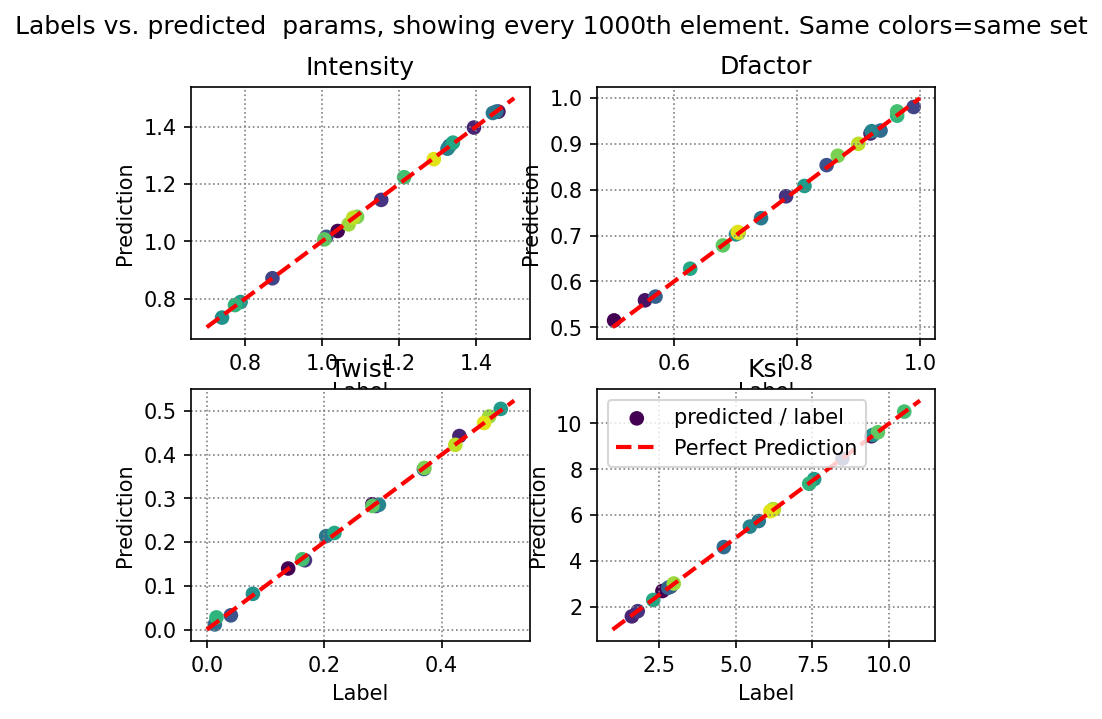

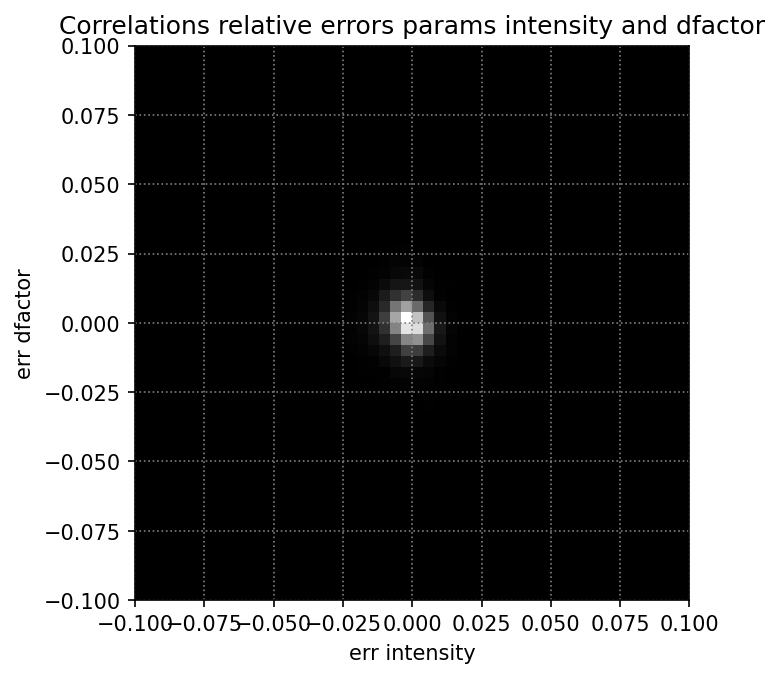

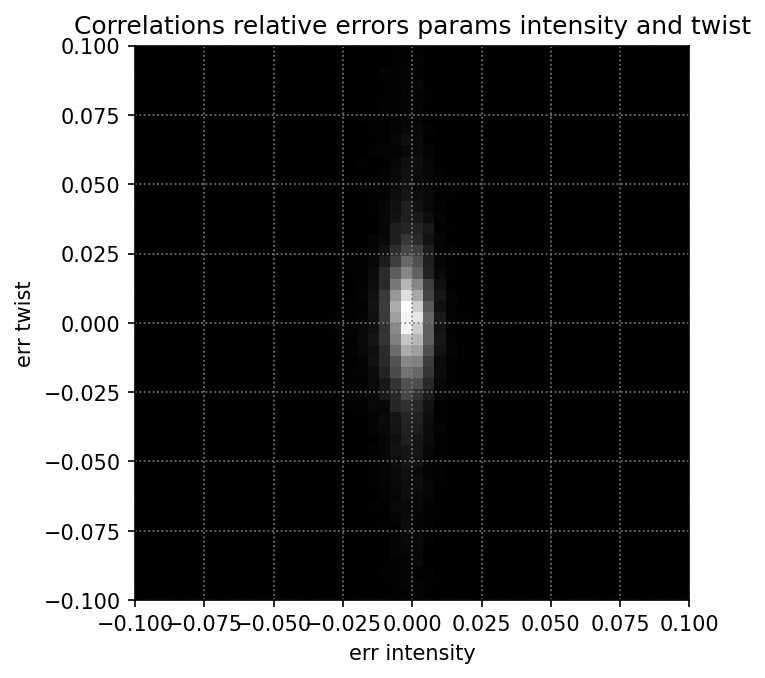

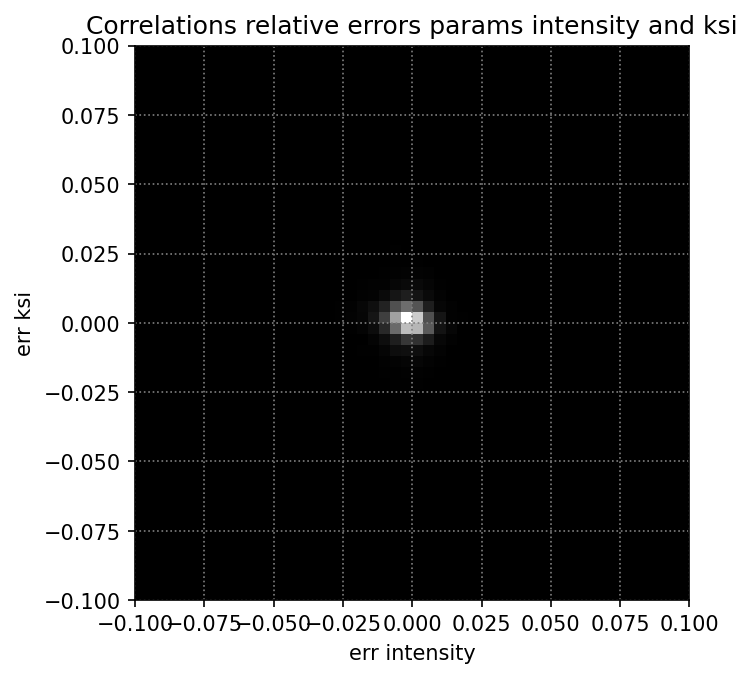

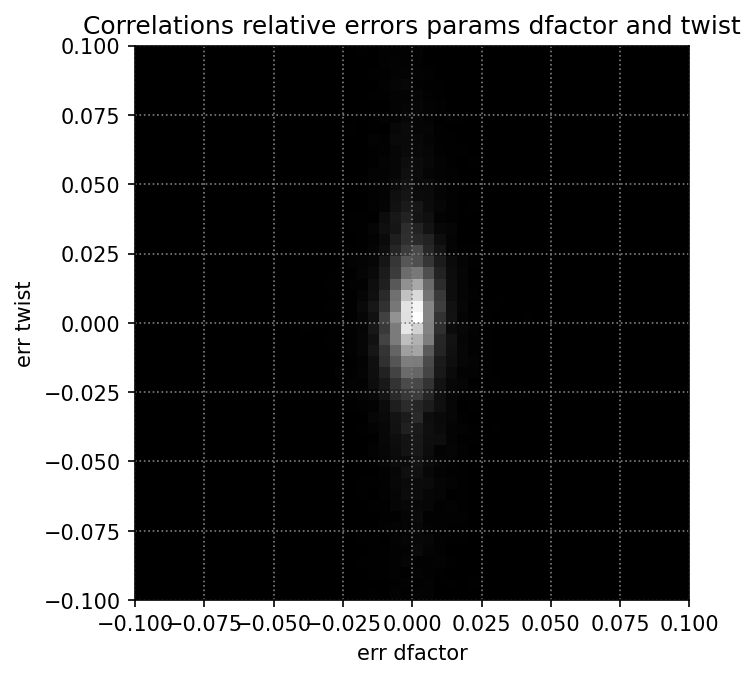

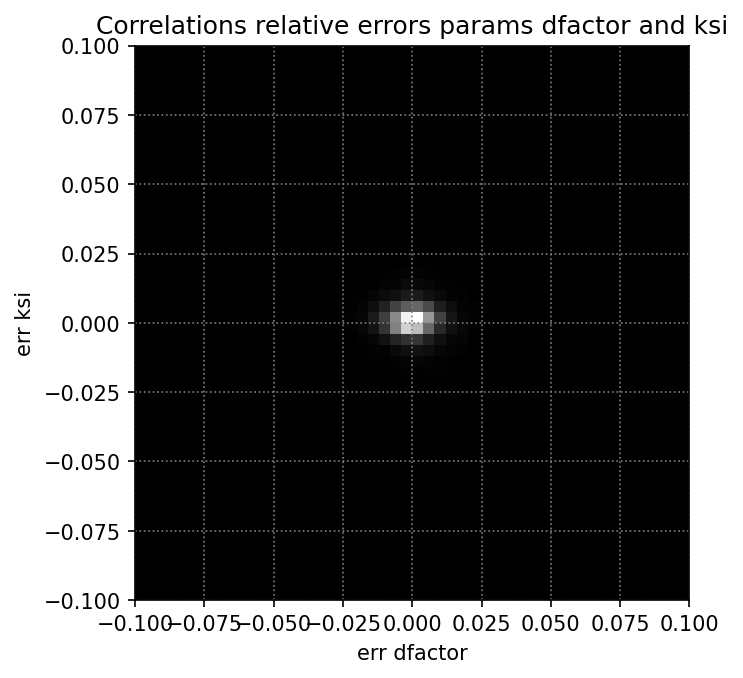

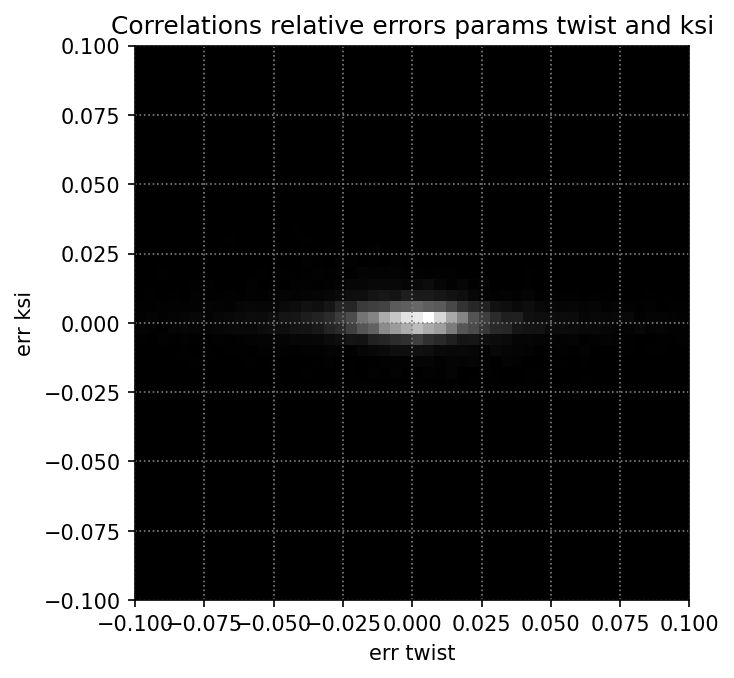

In [51]:
# CHECKS
"""
In this section, we evaluate the fit by plotting several monitored parameters, like mean absolute error.
"""
%matplotlib inline
# Plot training & validation Mean Absolute Error values:
plt.figure()
plt.plot(history.history['mean_absolute_error'])
plt.plot(history.history['val_mean_absolute_error'])
plt.title('Model Mean Absolute Error')
plt.ylabel('Mean Absolute Error')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


# Predict on test data
y_pred = cnn_model.predict(x_test)
# Calculate MSE
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error (MSE): {mse:.4f}")


# all 4 parameters pred + label:
for i in range(5):
    print("Predicted: ", y_pred[i])
    print("Label: ", y_test[i])

    
    
# HISTOGRAMS RELATIVE
plt.figure()
fig, axs = plt.subplots(2, 2)
axs[0, 0].hist((y_pred[:,0]-y_test[:,0])/y_test[:,0], bins=30)
axs[0, 0].set_title("Intensity")
axs[0, 1].hist((y_pred[:,1]-y_test[:,1])/y_test[:,1], bins=30)
axs[0, 1].set_title("Dfactor")
axs[1, 0].hist((y_pred[:,2]-y_test[:,2])/y_test[:,2], bins=50000) # some outliers!!
axs[1, 0].set_title("Twist")
axs[1, 0].set_xlim((-0.1, 0.1))
axs[1, 1].hist((y_pred[:,3]-y_test[:,3])/y_test[:,3], bins=30)
axs[1, 1].set_title("Ksi")
plt.suptitle("Distribution of predicted parameters (%)")
plt.show()


# HISTOGRAMS ABSOLUTE
plt.figure()
fig, axs = plt.subplots(2, 2)
axs[0, 0].hist(y_pred[:,0], bins=100)
axs[0, 0].set_title("Intensity")
axs[0, 1].hist(y_pred[:,1], bins=100)
axs[0, 1].set_title("Dfactor")
axs[1, 0].hist(y_pred[:,2], bins=100)
axs[1, 0].set_title("Twist")
axs[1, 1].hist(y_pred[:,3], bins=100)
axs[1, 1].set_title("Ksi")
plt.suptitle("Distribution of predicted parameters (abs)")
plt.show()


# EACH PARAMETER SEPARATELY:

fig, axs = plt.subplots(2, 2)

norm = Normalize(vmin=0, vmax=len(y_pred)-1)
cmap = cm.get_cmap('viridis')
colors = cmap(norm(range(len(y_pred))))
slicing = 1000

param_index = 0  # Index of the parameter to plot
axs[0,0].scatter(y_test[::slicing, param_index], y_pred[::slicing, param_index], c=colors[::slicing], label='predicted / label')
axs[0,0].plot([y_test[:, param_index].min(), y_test[:, param_index].max()], 
         [y_test[:, param_index].min(), y_test[:, param_index].max()], 
         color='red', linestyle='--', linewidth=2, label='Perfect Prediction')
axs[0,0].set_xlabel('Label')
axs[0,0].set_ylabel('Prediction')
axs[0,0].set_title("Intensity")

param_index = 1  # Index of the parameter to plot
axs[0,1].scatter(y_test[::slicing, param_index], y_pred[::slicing, param_index], c=colors[::slicing], label='predicted / label')
axs[0,1].plot([y_test[:, param_index].min(), y_test[:, param_index].max()], 
         [y_test[:, param_index].min(), y_test[:, param_index].max()], 
         color='red', linestyle='--', linewidth=2, label='Perfect Prediction')
axs[0,1].set_xlabel('Label')
axs[0,1].set_ylabel('Prediction')
axs[0,1].set_title("Dfactor")

param_index = 2  # Index of the parameter to plot
axs[1,0].scatter(y_test[::slicing, param_index], y_pred[::slicing, param_index], c=colors[::slicing],label='predicted / label')
axs[1,0].plot([y_test[:, param_index].min(), y_test[:, param_index].max()], 
         [y_test[:, param_index].min(), y_test[:, param_index].max()], 
         color='red', linestyle='--', linewidth=2, label='Perfect Prediction')
axs[1,0].set_xlabel('Label')
axs[1,0].set_ylabel('Prediction')
axs[1,0].set_title("Twist")

param_index = 3  # Index of the parameter to plot
axs[1,1].scatter(y_test[::slicing, param_index], y_pred[::slicing, param_index],c=colors[::slicing], label='predicted / label')
axs[1,1].plot([y_test[:, param_index].min(), y_test[:, param_index].max()], 
         [y_test[:, param_index].min(), y_test[:, param_index].max()], 
         color='red', linestyle='--', linewidth=2, label='Perfect Prediction')
axs[1,1].set_xlabel('Label')
axs[1,1].set_ylabel('Prediction')
axs[1,1].set_title("Ksi")


plt.suptitle(f'Labels vs. predicted  params, showing every {slicing}th element. Same colors=same set')
plt.legend()
plt.show()



# KORELACIJE NAPAK:
dicterr={0:"intensity", 1:"dfactor", 2:"twist", 3:"ksi"}
range1 = [[-0.1, 0.1],[-0.1, 0.1]]
for i1 in [0,1,2,3]:
    for i2 in [0,1,2,3]:
        if i1 != i2 and i1 < i2:
            plt.figure()
            plt.title(f"Correlations relative errors params {dicterr[i1]} and {dicterr[i2]}" )
            plt.hist2d((y_pred[:,i1]-y_test[:,i1])/y_test[:,i1], (y_pred[:,i2]-y_test[:,i2])/y_test[:,i2], bins=[50, 50], range=range1, cmap='grey')
            plt.xlabel(f"err {dicterr[i1]}")
            plt.ylabel(f"err {dicterr[i2]}")
            plt.gca().set_aspect('equal', adjustable='box')
            plt.show()

In [26]:
"""
Feed experimental data to check results:
"""

# def pixelate(img, resolution):
#     height, width, _ = img.shape
    
#     # Calculate the block size
#     block_height = height // resolution
#     block_width = width // resolution
    
#     # Resize the image to the desired resolution
#     resized_img = resize(img, (block_height * resolution, block_width * resolution), preserve_range=False)
#     new_img = np.zeros((resolution, resolution,3))

#     # Iterate over each block
#     for i in range(0, block_height * resolution, block_height):
#         for j in range(0, block_width * resolution, block_width):
#             # Calculate the average color of the block
#             avg_color = np.mean(resized_img[i:i+block_height, j:j+block_width], axis=(0, 1))#.astype(np.uint8)
#             # Set the pixels in the block to the average color
#             new_img[int(i/block_height), int(j/block_height)] = avg_color
#             #print(new_img[int(i/block_height), int(j/block_height)])
#     #new_img = downscale_local_mean(img,(resolution,resolution))
#     return new_img


# fnames = sorted(glob.glob("dtmm_measurement_2/dtmm2*.JPG"))#[::3]
# raws = [plt.imread(fname) for fname in sorted(fnames)]

# I,J = 990-20,2710-20
# DI,DJ = 610+40,610+40

# images = []

# for im in raws:
#     im = im[I:I+DI,J:J+DJ]
#     images.append(im)
#     #plt.figure()
#     #plt.imshow(im)
    
# cimages = []

# for i,im in enumerate(images):
#     im = pixelate(im/255., resolution=16)
#     cimages.append(im)
    

# experimental_pred = cnn_model.predict(cimages)

'\nFeed experimental data to check results:\n'